# Time-related feature engineering
- 자전거 대여 수요 회귀 작업에 시가노 관련 특성을 활용하는 다양한 전략을 소개
- 비즈니스 주기(일, 주, 월)과 연간 시즌 주기에 의존한다.
#
- `sklearn.preprocessing.SplineTransformer` 클래스와 `extrapolation = "periodic"` 옵션을 사용하여 주기적인 특성 엔지니어링을 수행

## Data exploration on the Bike Sharing Demand dataset

In [1]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame

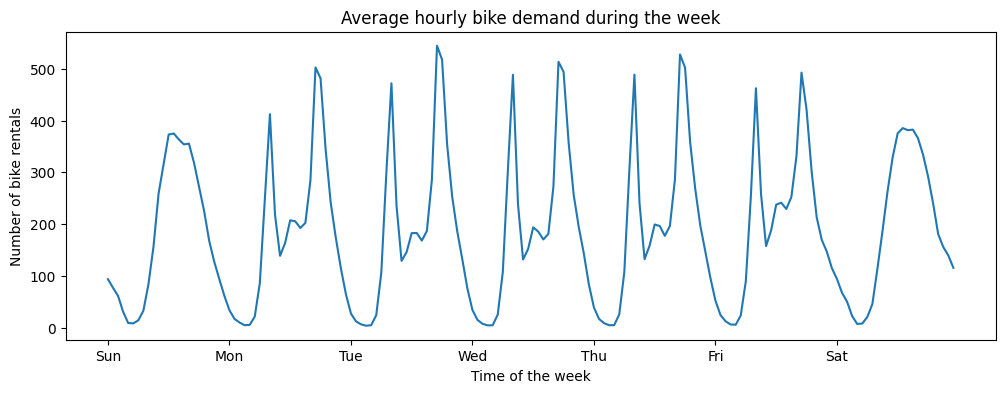

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [3]:
df["count"].max()

977

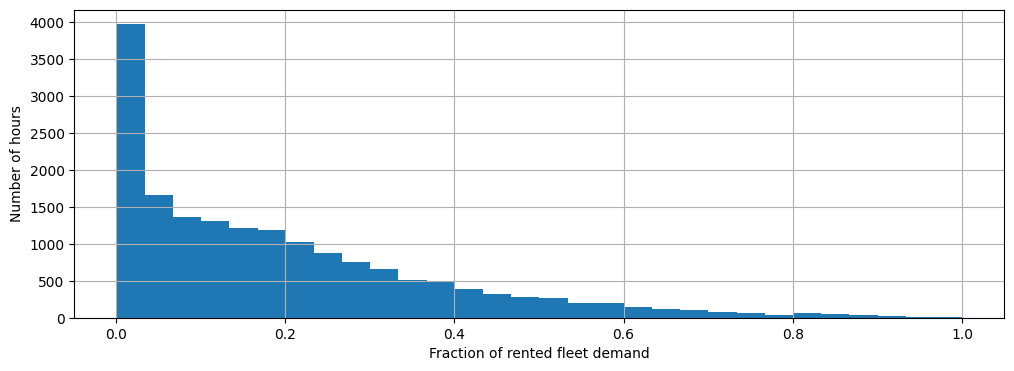

In [4]:
y = df["count"] / df["count"].max()

fig, ax = plt.subplots(figsize=(12, 4))
y.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

In [5]:
X = df.drop("count", axis="columns")
X

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981


In [6]:
X["weather"].value_counts()

weather
clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: count, dtype: int64

In [7]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

X["weather"].value_counts()

weather
clear    11413
misty     4544
rain      1422
Name: count, dtype: int64

In [8]:
X["season"].value_counts()

season
fall      4496
summer    4409
spring    4242
winter    4232
Name: count, dtype: int64

## Time-based cross-validation

In [9]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [10]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

X.iloc[test_0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
12379,summer,1,6,0,False,2,True,clear,22.14,25.760,0.68,27.9993
12380,summer,1,6,1,False,2,True,misty,21.32,25.000,0.77,22.0028
12381,summer,1,6,2,False,2,True,rain,21.32,25.000,0.72,19.9995
12382,summer,1,6,3,False,2,True,rain,20.50,24.240,0.82,12.9980
12383,summer,1,6,4,False,2,True,rain,20.50,24.240,0.82,12.9980
...,...,...,...,...,...,...,...,...,...,...,...,...
13374,fall,1,7,11,False,1,True,clear,34.44,40.150,0.53,15.0013
13375,fall,1,7,12,False,1,True,clear,34.44,39.395,0.49,8.9981
13376,fall,1,7,13,False,1,True,clear,34.44,39.395,0.49,19.0012
13377,fall,1,7,14,False,1,True,clear,36.08,40.910,0.42,7.0015


In [11]:
X.iloc[train_0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
2331,summer,0,4,1,False,2,True,misty,25.42,31.060,0.50,6.0032
2332,summer,0,4,2,False,2,True,misty,24.60,31.060,0.53,8.9981
2333,summer,0,4,3,False,2,True,misty,23.78,27.275,0.56,8.9981
2334,summer,0,4,4,False,2,True,misty,22.96,26.515,0.64,8.9981
2335,summer,0,4,5,False,2,True,misty,22.14,25.760,0.68,8.9981
...,...,...,...,...,...,...,...,...,...,...,...,...
12326,summer,1,6,19,False,6,False,clear,26.24,31.060,0.36,11.0014
12327,summer,1,6,20,False,6,False,clear,25.42,31.060,0.35,19.0012
12328,summer,1,6,21,False,6,False,clear,24.60,31.060,0.40,7.0015
12329,summer,1,6,22,False,6,False,clear,23.78,27.275,0.46,8.9981


In [13]:
train_4, test_4 = all_splits[4]

X.iloc[test_4]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
16379,winter,1,11,5,False,2,True,misty,13.94,16.665,0.66,8.9981
16380,winter,1,11,6,False,2,True,misty,13.94,16.665,0.71,11.0014
16381,winter,1,11,7,False,2,True,clear,13.12,16.665,0.76,6.0032
16382,winter,1,11,8,False,2,True,clear,13.94,16.665,0.71,8.9981
16383,winter,1,11,9,False,2,True,misty,14.76,18.940,0.71,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981


In [14]:
X.iloc[train_4]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
6331,winter,0,9,9,False,1,True,misty,26.24,28.790,0.89,12.9980
6332,winter,0,9,10,False,1,True,misty,26.24,28.790,0.89,12.9980
6333,winter,0,9,11,False,1,True,clear,27.88,31.820,0.79,15.0013
6334,winter,0,9,12,False,1,True,misty,27.88,31.820,0.79,11.0014
6335,winter,0,9,13,False,1,True,misty,28.70,33.335,0.74,11.0014
...,...,...,...,...,...,...,...,...,...,...,...,...
16326,winter,1,11,0,False,0,False,misty,12.30,15.150,0.70,11.0014
16327,winter,1,11,1,False,0,False,clear,12.30,14.395,0.70,12.9980
16328,winter,1,11,2,False,0,False,clear,11.48,14.395,0.81,7.0015
16329,winter,1,11,3,False,0,False,misty,12.30,15.150,0.81,11.0014


## Gradient Boosting

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]
categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]
ordinal_encoder = OrdinalEncoder(categories=categories)


gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        # 다음 파이프라인 단계에서 HistGradientBoostingRegressor에서 범주형 변수를 지정하기 쉽게 하기 위해 짧은 특성 이름 사용
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
        random_state=42,
    ),
).set_output(transform="pandas")

In [16]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.044 +/- 0.003
Root Mean Squared Error: 0.068 +/- 0.005


## Naive linear regression

In [17]:
import numpy as np

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)


evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.142 +/- 0.014
Root Mean Squared Error: 0.184 +/- 0.020


## Time-stepes as categories

In [18]:
one_hot_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "weekday", "month"]),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

evaluate(one_hot_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.099 +/- 0.011
Root Mean Squared Error: 0.131 +/- 0.011


## Trigonometric features

In [19]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

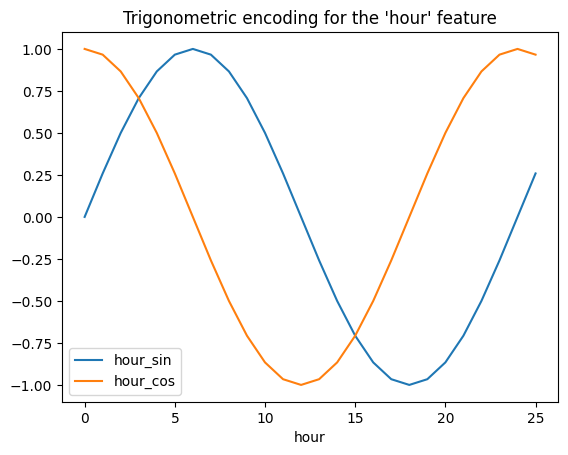

In [20]:
import pandas as pd

hour_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns=["hour"],
)
hour_df["hour_sin"] = sin_transformer(24).fit_transform(hour_df)["hour"]
hour_df["hour_cos"] = cos_transformer(24).fit_transform(hour_df)["hour"]
hour_df.plot(x="hour")
_ = plt.title("Trigonometric encoding for the 'hour' feature")

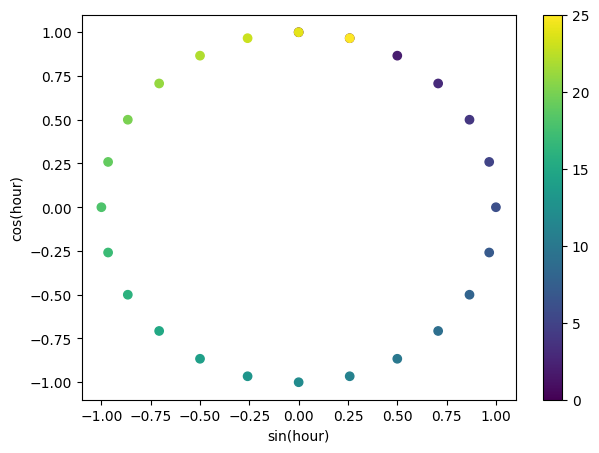

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(hour_df["hour_sin"], hour_df["hour_cos"], c=hour_df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

In [22]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.125 +/- 0.014
Root Mean Squared Error: 0.166 +/- 0.020


## Periodic spline features

In [23]:
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic와 include_bias를 True로 설정
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

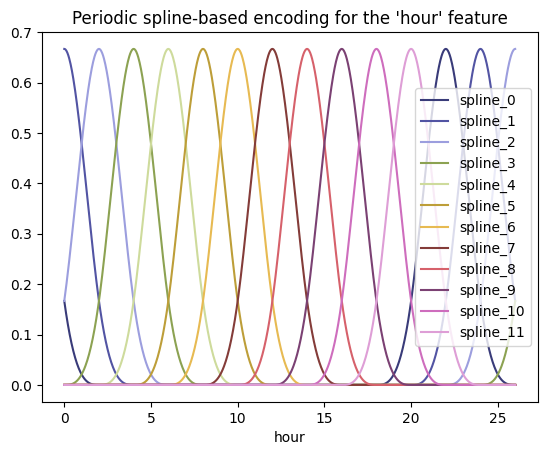

In [24]:
hour_df = pd.DataFrame(
    np.linspace(0, 26, 1000).reshape(-1, 1),
    columns=["hour"],
)
splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
pd.concat([hour_df, splines_df], axis="columns").plot(x="hour", cmap=plt.cm.tab20b)
_ = plt.title("Periodic spline-based encoding for the 'hour' feature")

In [25]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.097 +/- 0.011
Root Mean Squared Error: 0.132 +/- 0.013


## Qualitative analysis of the impact of features on linear model predictions

In [26]:
naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_0])

one_hot_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_0])

cyclic_cossin_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X.iloc[test_0])

cyclic_spline_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[test_0])

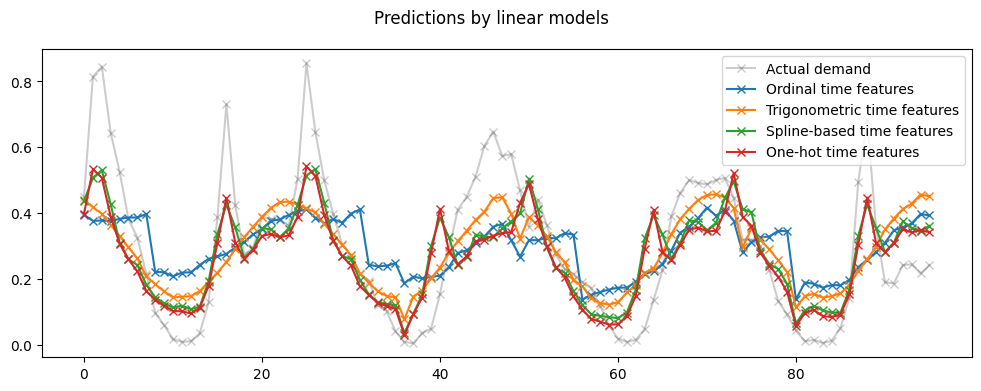

In [27]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(naive_linear_predictions[last_hours], "x-", label="Ordinal time features")
ax.plot(
    cyclic_cossin_linear_predictions[last_hours],
    "x-",
    label="Trigonometric time features",
)
ax.plot(
    cyclic_spline_linear_predictions[last_hours],
    "x-",
    label="Spline-based time features",
)
ax.plot(
    one_hot_linear_predictions[last_hours],
    "x-",
    label="One-hot time features",
)
_ = ax.legend()

In [28]:
naive_linear_pipeline[:-1].transform(X).shape

(17379, 19)

In [29]:
one_hot_linear_pipeline[:-1].transform(X).shape

(17379, 59)

In [30]:
cyclic_cossin_linear_pipeline[:-1].transform(X).shape

(17379, 22)

In [31]:
cyclic_spline_linear_pipeline[:-1].transform(X).shape

(17379, 37)

## Modeling pairwise interactions with splines and polynomial features

In [32]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures

hour_workday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("workingday", FunctionTransformer(lambda x: x == "True"), ["workingday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

In [33]:
cyclic_spline_interactions_pipeline = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions", hour_workday_interaction),
        ]
    ),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_interactions_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.078 +/- 0.009
Root Mean Squared Error: 0.104 +/- 0.009


## Modeling non-linear feature interactions with kernels

In [34]:
from sklearn.kernel_approximation import Nystroem

cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.053 +/- 0.002
Root Mean Squared Error: 0.076 +/- 0.004


In [35]:
one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "weekday", "month"]),
        ],
        remainder="passthrough",
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.082 +/- 0.006
Root Mean Squared Error: 0.111 +/- 0.011


In [36]:
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

one_hot_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_poly_predictions = one_hot_poly_pipeline.predict(X.iloc[test_0])

cyclic_spline_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[test_0])

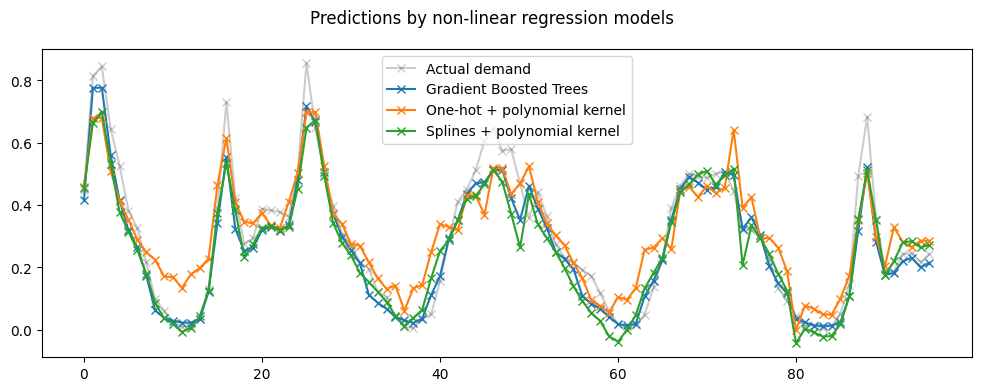

In [37]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    gbrt_predictions[last_hours],
    "x-",
    label="Gradient Boosted Trees",
)
ax.plot(
    one_hot_poly_predictions[last_hours],
    "x-",
    label="One-hot + polynomial kernel",
)
ax.plot(
    cyclic_spline_poly_predictions[last_hours],
    "x-",
    label="Splines + polynomial kernel",
)
_ = ax.legend()

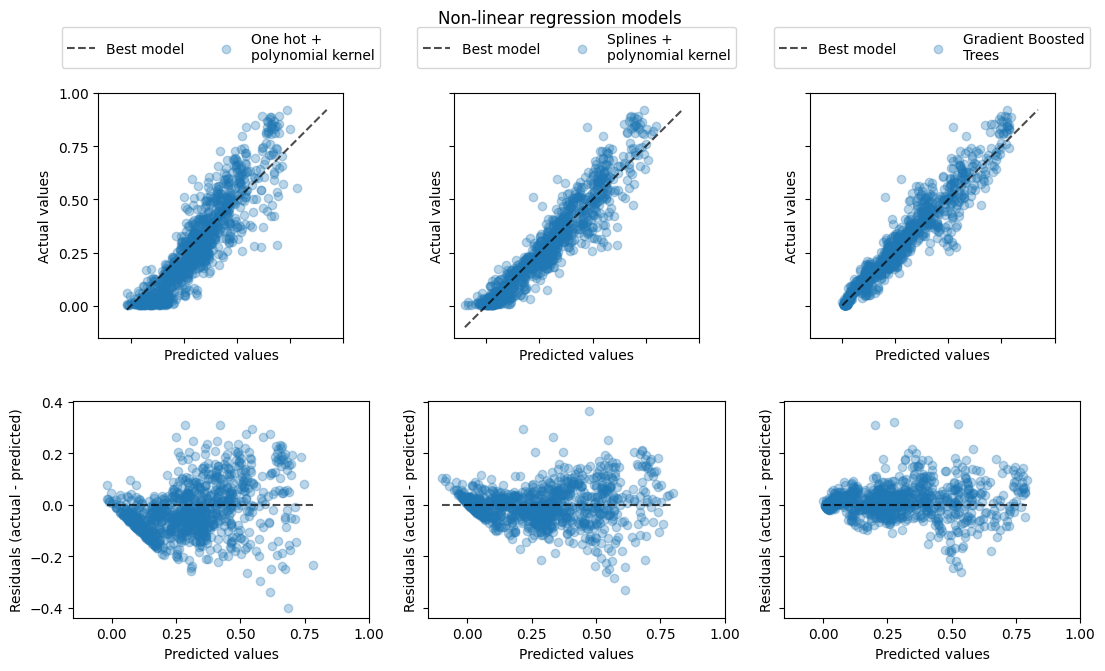

In [38]:
from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 7), sharex=True, sharey="row")
fig.suptitle("Non-linear regression models", y=1.0)
predictions = [
    one_hot_poly_predictions,
    cyclic_spline_poly_predictions,
    gbrt_predictions,
]
labels = [
    "One hot +\npolynomial kernel",
    "Splines +\npolynomial kernel",
    "Gradient Boosted\nTrees",
]
plot_kinds = ["actual_vs_predicted", "residual_vs_predicted"]
for axis_idx, kind in enumerate(plot_kinds):
    for ax, pred, label in zip(axes[axis_idx], predictions, labels):
        disp = PredictionErrorDisplay.from_predictions(
            y_true=y.iloc[test_0],
            y_pred=pred,
            kind=kind,
            scatter_kwargs={"alpha": 0.3},
            ax=ax,
        )
        ax.set_xticks(np.linspace(0, 1, num=5))
        if axis_idx == 0:
            ax.set_yticks(np.linspace(0, 1, num=5))
            ax.legend(
                ["Best model", label],
                loc="upper center",
                bbox_to_anchor=(0.5, 1.3),
                ncol=2,
            )
        ax.set_aspect("equal", adjustable="box")
plt.show()